In [1]:
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [2]:
np.random.seed(9876)

In [3]:
class PredatorPreyModel:
    def __init__(self, datapoints):
        
        self.datapoints = datapoints
        self.n_data = self.datapoints.shape[0]
        self.t_span = [0, self.datapoints[-1]]
        
    def dydx(self, t, y, a, b, c, d):
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):
        
        P_0, Q_0, a, b, c, d = np.exp(parameters)
        
        self.y = solve_ivp(self.dydx, self.t_span, np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=self.datapoints) 
        
        if self.y.success:
            return self.y.y.flatten()
        else:
            return np.nan
        
    def get_qoi(self):
        return self.y.success

In [4]:
P_0 = 10
Q_0 = 5
a = 1.0
b = 0.3
c = 0.2
d = 1.0

true_parameters = np.log(np.array([P_0, Q_0, a, b, c, d]))
t_span = [0,12]
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

my_model = PredatorPreyModel(t_eval)
y_true = my_model(true_parameters)

In [5]:
n_data_fine = 25
t_eval_fine = np.linspace(t_span[0], t_span[1], n_data_fine)
my_fine_model = PredatorPreyModel(t_eval_fine)

n_data_coarse = 13
t_eval_coarse = t_eval_fine[:n_data_coarse]
my_coarse_model = PredatorPreyModel(t_eval_coarse)

In [6]:
sigma = 1.0

noise_fine = np.random.normal(scale=sigma, size=(t_eval_fine.size,2))
data_fine = my_fine_model(true_parameters) + np.hstack((noise_fine[:,0], noise_fine[:,1]))
data_fine[data_fine < 0] = 0

noise_coarse = np.hstack((noise_fine[:n_data_coarse,0], noise_fine[:n_data_coarse,1]))
data_coarse = my_coarse_model(true_parameters) + noise_coarse
data_coarse[data_coarse < 0] = 0

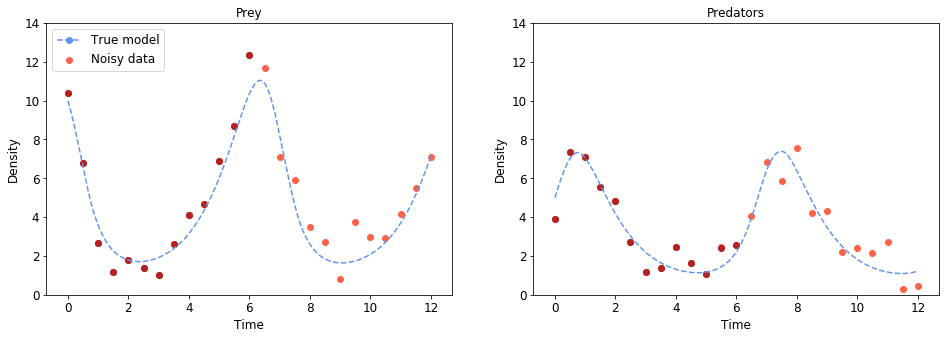

In [7]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true[:n_eval], '--', color='cornflowerblue')
#axes[0].scatter(t_eval_fine, data_fine[:n_data_fine]-noise_fine[:,0], color='cornflowerblue')
axes[0].scatter(t_eval_fine, data_fine[:n_data_fine], color='tomato', label='Noisy data')
axes[0].scatter(t_eval_coarse, data_coarse[:n_data_coarse], color='firebrick')
axes[0].plot([], [], '--o', color='cornflowerblue', label = 'True model')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true[n_eval:], '--', color='cornflowerblue')
#axes[1].scatter(t_eval_fine, data_fine[n_data_fine:]-noise_fine[:,1], color='cornflowerblue')
axes[1].scatter(t_eval_fine, data_fine[n_data_fine:], color='tomato', label='Noisy data')
axes[1].scatter(t_eval_coarse, data_coarse[n_data_coarse:], color='firebrick')
#axes[1].plot([], [], '--o', color='#1f77b4', label = 'True model')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
#axes[1].legend(loc=2, fontsize=12)

plt.show()

In [8]:
mean_prior = np.array([np.log(data_fine[0]), np.log(data_fine[n_data_fine]), 0, -1, -1.5, 0])
cov_prior = np.array([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])

my_prior = stats.multivariate_normal(mean_prior, cov_prior)

In [9]:
cov_likelihood_fine = sigma**2*np.eye(data_fine.size)
cov_likelihood_coarse = sigma**2*np.eye(data_coarse.size)/2

my_loglike_fine = tda.LogLike(data_fine, cov_likelihood_fine)
my_loglike_coarse = tda.LogLike(data_coarse, cov_likelihood_coarse)

In [10]:
my_link_factory_coarse = tda.BlackBoxLinkFactory(my_coarse_model, my_prior, my_loglike_coarse, True)
my_link_factory_fine = tda.BlackBoxLinkFactory(my_fine_model, my_prior, my_loglike_fine, True)

In [11]:
MAP = tda.get_MAP(my_link_factory_fine)

In [12]:
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

am_cov = np.eye(true_parameters.size)
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

In [13]:
my_chain = tda.DAChain(my_link_factory_coarse, my_link_factory_fine, my_proposal, subsampling_rate=5, initial_parameters=MAP)

In [14]:
my_chain.sample(6000)

Running chain, α_c = 0.308, α_f = 0.26: 100%|██████████| 6000/6000 [01:46<00:00, 56.16it/s]


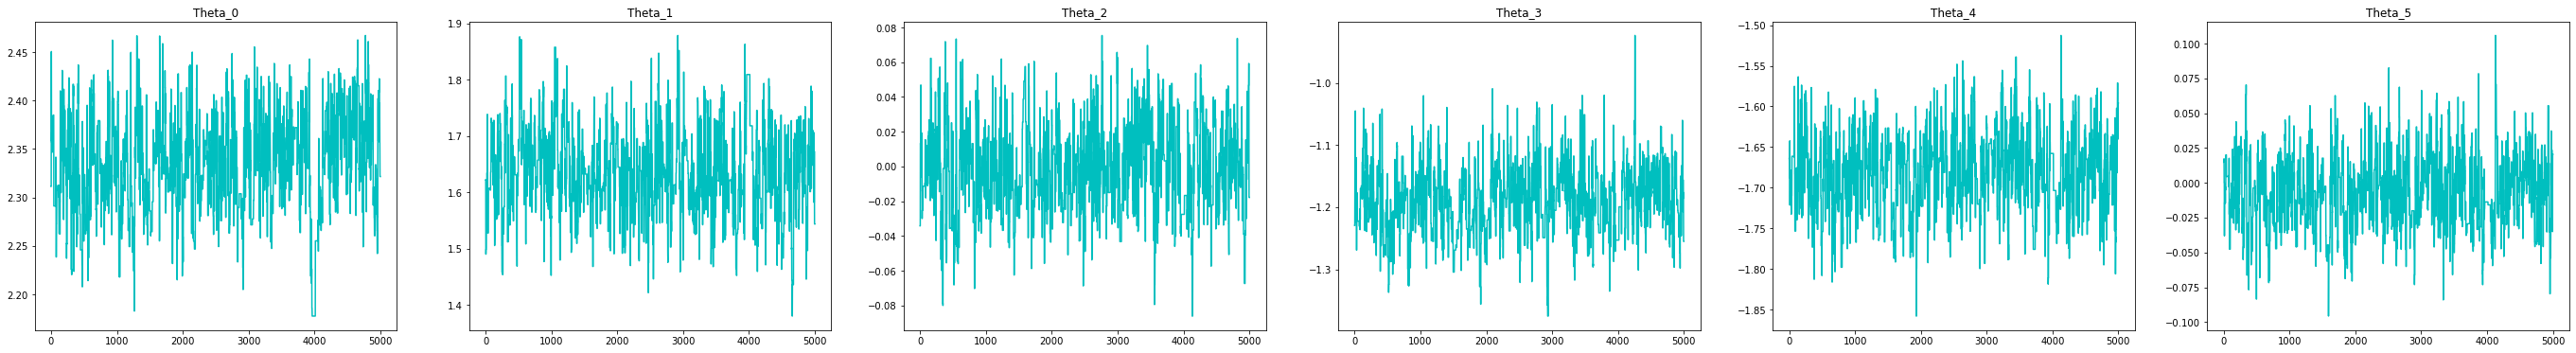

In [15]:
burnin = 1000
parameters_fine = tda.get_parameters(my_chain)
tda.plot_parameters(parameters_fine, indices=list(range(6)), burnin=burnin)

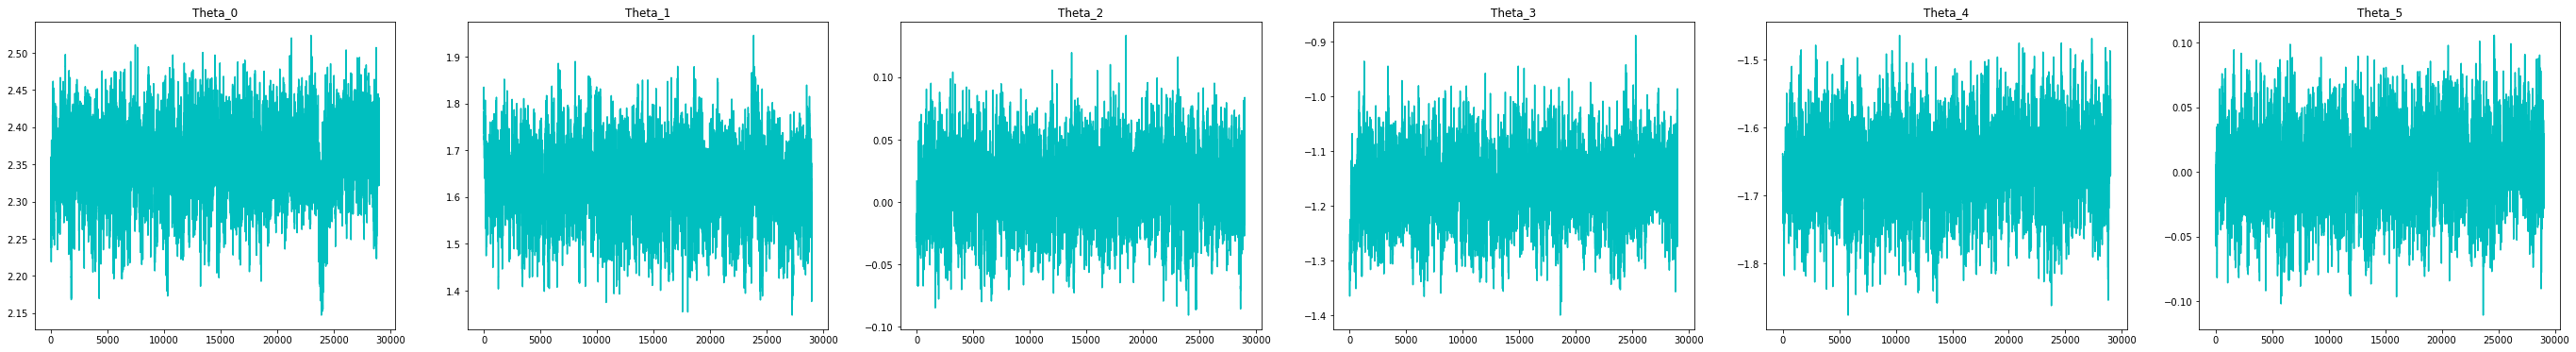

In [16]:
parameters_coarse = tda.get_parameters(my_chain, level='coarse')
tda.plot_parameters(parameters_coarse, indices=list(range(6)), burnin=burnin)

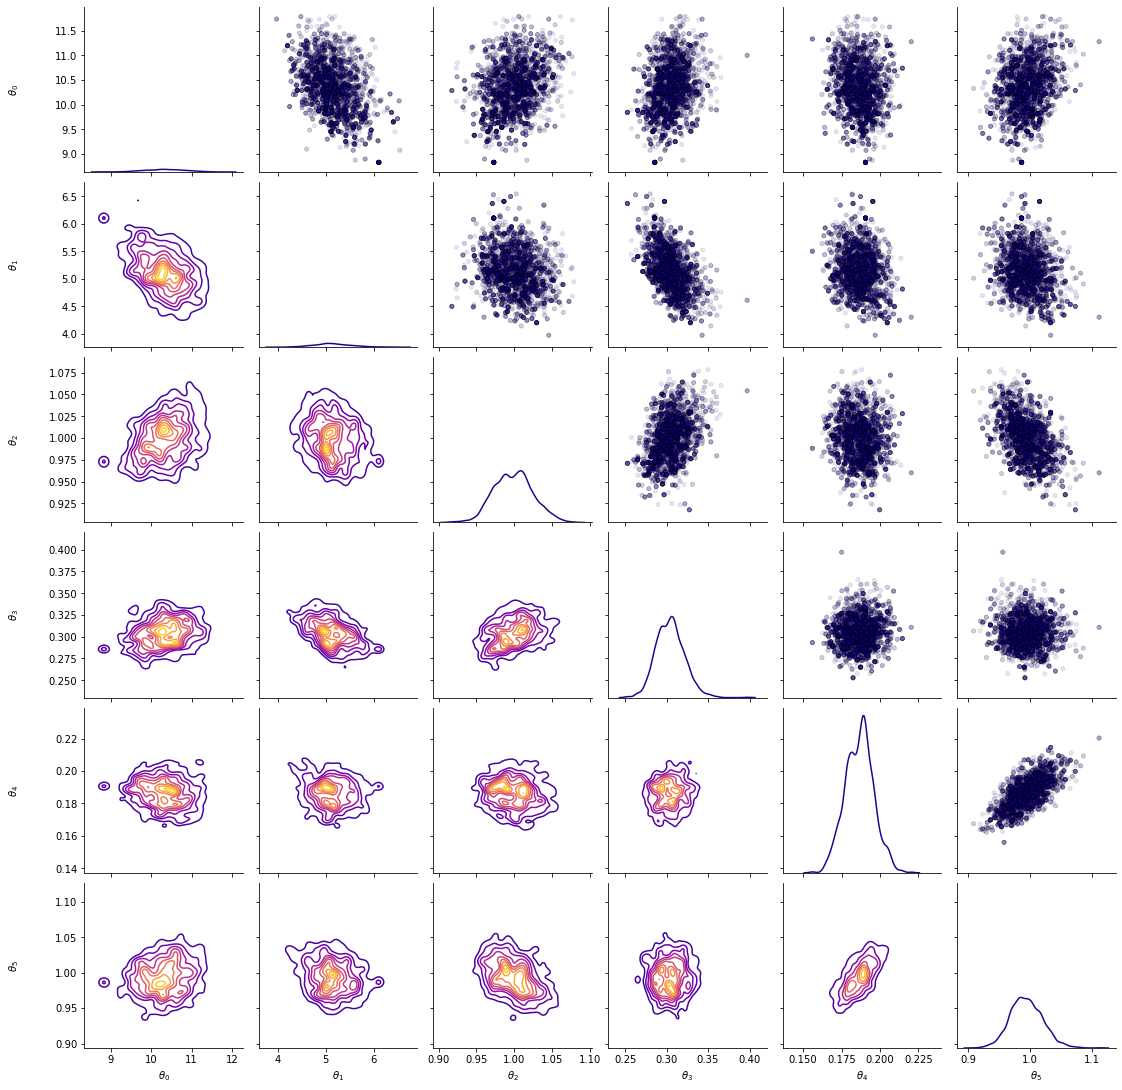

In [17]:
tda.plot_parameter_matrix(np.exp(parameters_fine), indices=list(range(6)), burnin=burnin)